In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as req
import json
import os


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 修改中文字體
plt.rcParams['axes.unicode_minus'] = False # 顯示負號

data process

In [2]:
df = pd.read_csv('所得房價消費分析_處理後.csv')
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.shape

(49086, 11)

In [3]:
df.head()

,縣市代碼,縣市名稱,鄉鎮市區代碼,鄉鎮市區名稱,行業名稱,平均開立張數,平均開立金額,平均客單價,year,month,縣鄉鎮市區
0,F,新北市,16,鶯歌區,食品、飲料及菸草製品零售業,4541,4522267,996,2021,10,新北市鶯歌區
1,B,臺中市,57,神岡區,餐飲業,5126,743276,145,2021,10,臺中市神岡區
2,O,新竹市,1,東 區,食品、飲料及菸草製品零售業,5486,1347875,246,2021,10,新竹市東 區
3,D,臺南市,70,新市區,餐飲業,5632,799366,142,2021,10,臺南市新市區
4,T,屏東縣,3,東港鎮,餐飲業,6055,1071876,177,2021,10,屏東縣東港鎮


### Target variables
* 平均開立金額，平均客單價，平均開立張數
* 以「平均開立金額」作為預測目標

###  Features
* 縣市名稱，鄉鎮市區名稱，行業名稱，縣鄉鎮市區，year，month
* 進行one-hot encoding

In [4]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

# 透過GOOGLE MAP的網址列轉址
def get_current_location(location, header):
    my_place = location
    google_url = f'https://www.google.com.tw/search?tbm=map&authuser=0&hl=zh-TW&gl=tw&q={my_place}'
    res = req.get(google_url, headers = header)
    google_data = json.loads(res.text[5:])
    return google_data[1][0][1], google_data[1][0][2]

# 將行政區轉換成經緯度
def address_to_latlng(address):
    lat, lng = get_current_location(address, headers)
    return lat, lng

# 改動資料
# df[['lat', 'lng']] = df['縣鄉鎮市區'].apply(lambda x: pd.Series(address_to_latlng(x)))

以2021年資料為例：

In [5]:
from requests.exceptions import ConnectionError

df2021 = df[df['year'] == 2021]

def safe_address_to_latlng(address, retries=3):
	for _ in range(retries):
		try:
			return address_to_latlng(address)
		except ConnectionError:
			print(f"Connection error for address {address}. Retrying...")
	return None, None

# 改動資料
df2021[['lat', 'lng']] = df2021['縣鄉鎮市區'].apply(lambda x: pd.Series(safe_address_to_latlng(x)))

Connection error for address 臺中市南　區. Retrying...
Connection error for address 臺中市南　區. Retrying...
Connection error for address 臺中市南　區. Retrying...
Connection error for address 臺南市中西區. Retrying...
Connection error for address 臺南市中西區. Retrying...
Connection error for address 臺南市中西區. Retrying...
Connection error for address 臺北市松山區. Retrying...
Connection error for address 臺北市松山區. Retrying...
Connection error for address 臺北市松山區. Retrying...
Connection error for address 臺南市中西區. Retrying...
Connection error for address 臺南市中西區. Retrying...
Connection error for address 臺南市中西區. Retrying...
Connection error for address 嘉義市東　區. Retrying...
Connection error for address 嘉義市東　區. Retrying...
Connection error for address 嘉義市東　區. Retrying...
Connection error for address 屏東縣琉球鄉. Retrying...
Connection error for address 屏東縣琉球鄉. Retrying...
Connection error for address 屏東縣琉球鄉. Retrying...
Connection error for address 臺北市中山區. Retrying...
Connection error for address 臺北市中山區. Retrying...
Connection error for

In [6]:
categorical_columns = ['行業名稱']

encoder = OneHotEncoder(sparse_output=False)

# 進行 One-Hot Encoding
encoded_data = encoder.fit_transform(df2021[categorical_columns])

# 將編碼後的資料轉換為 DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

# 將編碼後的資料與原始資料合併
df2021 = df2021.drop(columns=categorical_columns)
encoded_df.index = df2021.index
df2021 = pd.concat([df2021, encoded_df], axis=1)

NameError: name 'df_2021' is not defined

In [7]:
# df2021.drop(columns=['縣鄉鎮市區', '縣市代碼','縣市名稱','鄉鎮市區代碼','鄉鎮市區名稱'], inplace=True)
df2021.head()

,縣市代碼,縣市名稱,鄉鎮市區代碼,鄉鎮市區名稱,平均開立張數,平均開立金額,平均客單價,year,month,縣鄉鎮市區,lat,lng
0,F,新北市,16,鶯歌區,4541,4522267,996,2021,10,新北市鶯歌區,121.349034,24.955179
1,B,臺中市,57,神岡區,5126,743276,145,2021,10,臺中市神岡區,120.672302,24.264081
2,O,新竹市,1,東 區,5486,1347875,246,2021,10,新竹市東 區,120.995794,24.788493
3,D,臺南市,70,新市區,5632,799366,142,2021,10,臺南市新市區,120.292618,23.082195
4,T,屏東縣,3,東港鎮,6055,1071876,177,2021,10,屏東縣東港鎮,120.469456,22.465252


In [8]:
df2021.to_csv('所得房價消費分析_處理後_2021.csv', index=False)

In [9]:
df2021 = pd.read_csv('所得房價消費分析_處理後_2021.csv')
# df2021.columns = ['平均開立張數','平均開立金額','平均客單價',
                #   'year','month','lat','lng','行業名稱_住宿服務業','行業名稱_便利商店','行業名稱_百貨公司',
                #   '行業名稱_綜合商品零售業','行業名稱_超級市場','行業名稱_零售式量販店','行業名稱_食品、飲料及菸草製品零售業','行業名稱_餐飲業']
df2021.head()

,縣市代碼,縣市名稱,鄉鎮市區代碼,鄉鎮市區名稱,平均開立張數,平均開立金額,平均客單價,year,month,縣鄉鎮市區,lat,lng
0,F,新北市,16,鶯歌區,4541,4522267,996,2021,10,新北市鶯歌區,121.349034,24.955179
1,B,臺中市,57,神岡區,5126,743276,145,2021,10,臺中市神岡區,120.672302,24.264081
2,O,新竹市,1,東 區,5486,1347875,246,2021,10,新竹市東 區,120.995794,24.788493
3,D,臺南市,70,新市區,5632,799366,142,2021,10,臺南市新市區,120.292618,23.082195
4,T,屏東縣,3,東港鎮,6055,1071876,177,2021,10,屏東縣東港鎮,120.469456,22.465252


In [40]:
df2021 = df2021[df2021['month'] == 1]
df2021.head()

,平均開立張數,平均開立金額,平均客單價,year,month,lat,lng,行業名稱_住宿服務業,行業名稱_便利商店,行業名稱_百貨公司,行業名稱_綜合商品零售業,行業名稱_超級市場,行業名稱_零售式量販店,行業名稱_食品、飲料及菸草製品零售業,行業名稱_餐飲業
9517,448.0,2382169.0,5323.0,2021.0,1.0,121.212611,25.062245,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9518,674.0,1485220.0,2204.0,2021.0,1.0,120.283739,22.625491,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9519,994.0,2011194.0,2023.0,2021.0,1.0,121.498002,24.990288,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9520,3004.0,414838.0,138.0,2021.0,1.0,121.562821,23.960526,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9521,3525.0,902813.0,256.0,2021.0,1.0,120.393878,22.506739,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
df2021 = df2021[df2021['month'] == 1]
# Features and target variable
X = df2021.drop(columns=['平均開立金額', 'year', 'month']) 
y = df2021['平均開立金額']  

消耗過多運算資源

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import StackingClassifier

stacking_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42)),
        ('xgb', XGBClassifier(random_state=42))
    ],
    final_estimator=LogisticRegression(),
    cv= None  # 減少分割數
)

stacking_model.fit(X_train, y_train)
stacking_test_accuracy = stacking_model.score(X_test, y_test)

# 最後沒有成功跑完

改使用caatboost

In [ ]:
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(
    iterations=500,       # 訓練迭代次數
    learning_rate=0.1,    # 學習率
    depth=6,              # 樹的深度
    loss_function='MAE',  # 使用 MAE 作為損失函數
    verbose=50            # 每 50 次輸出一次進度
)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

X_test['predicted_amount'] = y_pred
# 合併預測值與行業分布
X_test['actual_amount'] = y_test  

0:	learn: 3644175.8094303	total: 1.95ms	remaining: 972ms
50:	learn: 1178886.3795882	total: 68.9ms	remaining: 606ms
100:	learn: 821200.2907818	total: 131ms	remaining: 519ms
150:	learn: 460161.9590460	total: 192ms	remaining: 444ms
200:	learn: 368391.4982311	total: 255ms	remaining: 380ms
250:	learn: 345989.1070192	total: 317ms	remaining: 314ms
300:	learn: 323155.5336378	total: 457ms	remaining: 302ms
350:	learn: 292436.9934170	total: 521ms	remaining: 221ms
400:	learn: 262959.9141978	total: 580ms	remaining: 143ms
450:	learn: 254639.5526667	total: 643ms	remaining: 69.9ms
499:	learn: 244709.2632628	total: 737ms	remaining: 0us
Mean Absolute Error (MAE): 502590.49


In [58]:
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.2f}")

Mean Absolute Error (MAE): 502590.49
Mean Squared Error (MSE): 12681814093311.08
R^2 Score: 0.90


In [56]:
import matplotlib.pyplot as plt

# 行業名稱清單
industry_columns = [col for col in result.columns if '行業名稱' in col]

result_df = []
for industry in industry_columns:
    filtered_df = X_test[X_test[industry] == 1]
    summed_data = {
    'industry': industry,
    'predicted_amount_sum': filtered_df['predicted_amount'].sum(),
    'actual_amount_sum': filtered_df['actual_amount'].sum()
    }
    result_df.append(summed_data)
result_df = pd.DataFrame(result_df)
result_df['error'] = abs(result_df['predicted_amount_sum'] - result_df['actual_amount_sum'])
result_df

,industry,predicted_amount_sum,actual_amount_sum,error
0,行業名稱_住宿服務業,4.001043e+07,45920677.0,5.910246e+06
1,行業名稱_便利商店,1.074157e+08,106922538.0,4.931667e+05
2,行業名稱_百貨公司,2.859942e+08,229702130.0,5.629209e+07
3,行業名稱_綜合商品零售業,2.406938e+08,241730100.0,1.036278e+06
4,行業名稱_超級市場,5.073958e+07,50995954.0,2.563769e+05
5,行業名稱_零售式量販店,3.325384e+07,36463570.0,3.209734e+06
6,行業名稱_食品、飲料及菸草製品零售業,4.530414e+07,46422726.0,1.118589e+06
7,行業名稱_餐飲業,3.780204e+07,38070142.0,2.681016e+05


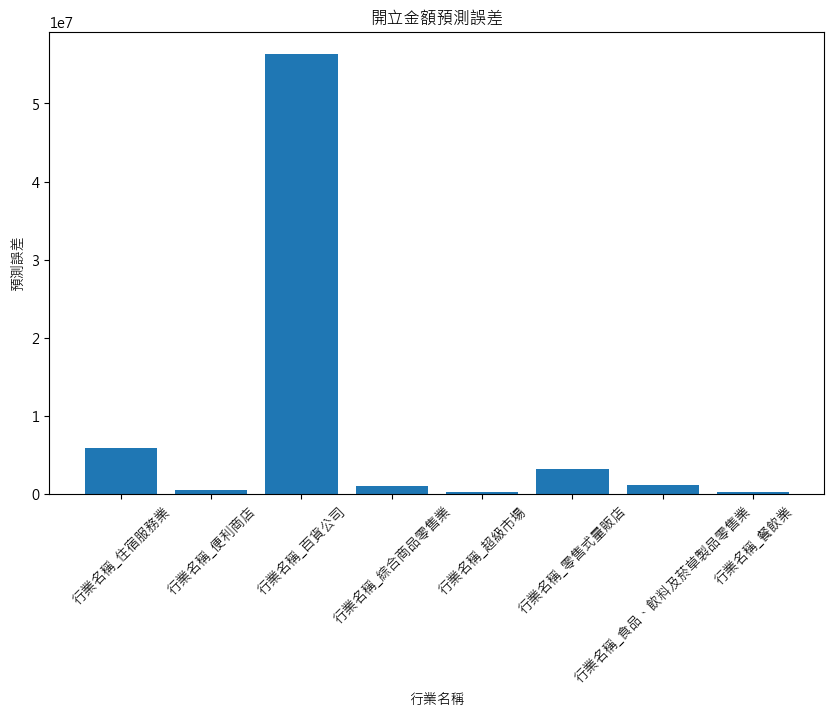

In [57]:
plt.figure(figsize=(10, 6))
plt.bar(result_df['industry'], result_df['error'])
plt.xlabel('行業名稱')
plt.ylabel('預測誤差')
plt.title('開立金額預測誤差')
plt.xticks(rotation=45)
plt.show()